In [ ]:
# 1
!nvidia-smi
import lightgbm as lgb
print('LightGBM version:', lgb.__version__)

Tue Jul 22 23:25:37 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 575.64.01              Driver Version: 576.80         CUDA Version: 12.9     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 4070 Ti     On  |   00000000:01:00.0  On |                  N/A |
| 30%   35C    P0             28W /  285W |    1739MiB /  12282MiB |      2%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [ ]:
# 2
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
# Common preprocessing & latest features (exp_04)
def preprocess(df):
    # TODO: implement exp_04 preprocessing steps (feature engineering, encoding, imputation)
    return df

# Load data
train = pd.read_csv('../data/train.csv')
test  = pd.read_csv('../data/test.csv')
train = preprocess(train)
test  = preprocess(test)
TARGET = 'Transported'
features = [c for c in train.columns if c not in ['PassengerId', TARGET]]

In [ ]:
# 3
from sklearn.model_selection import StratifiedGroupKFold
sgkf  = StratifiedGroupKFold(n_splits=5, shuffle=True, random_state=42)
groups = train['PassengerId'].str.split('_').str[0].astype(int)
oof_preds = np.zeros(len(train))
test_preds = np.zeros(len(test))


In [ ]:
# 4 モデル学習＆MLflowログ（CPUモード版）

import mlflow
import lightgbm as lgb
from lightgbm import early_stopping, log_evaluation
from sklearn.metrics import accuracy_score

# 実験名セット
mlflow.set_experiment('exp_06_lgbm_sgk')

# CPU 用 CONFIG（GPU 関連設定を削除して並列度最大化）
CONFIG = {
    'objective': 'binary',
    'metric': 'binary_error',
    'learning_rate': 0.01,
    'num_leaves': 31,
    'n_estimators': 1000,
    'random_state': 42,
    'n_jobs': -1,    # CPU 全コアを使う
}

# カテゴリ変数を category に変換
object_cols = train.select_dtypes(include=['object']).columns
for col in object_cols:
    train[col] = train[col].astype('category')
    test[col]  = test[col].astype('category')

with mlflow.start_run(run_name='exp_06_lgbm_sgk'):
    for fold, (tr_idx, val_idx) in enumerate(sgkf.split(train, train[TARGET], groups)):
        print(f'Fold {fold}')
        tr_data = lgb.Dataset(
            train.iloc[tr_idx][features],
            label=train.iloc[tr_idx][TARGET],
            categorical_feature='auto'
        )
        val_data = lgb.Dataset(
            train.iloc[val_idx][features],
            label=train.iloc[val_idx][TARGET],
            categorical_feature='auto'
        )

        model = lgb.train(
            CONFIG,
            tr_data,
            valid_sets=[val_data],
            callbacks=[
                early_stopping(stopping_rounds=50),
                log_evaluation(period=100)
            ]
        )

        oof_preds[val_idx] = (model.predict(train.iloc[val_idx][features]) > 0.5).astype(int)
        test_preds       += model.predict(test[features]) / sgkf.n_splits

    cv_acc = accuracy_score(train[TARGET], oof_preds)
    mlflow.log_metric('cv_acc', cv_acc)
    print(f'[exp_06_lgbm_sgk] cv_acc: {cv_acc:.4f}')


Fold 0
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 3539, number of negative: 3457
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001036 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1735
[LightGBM] [Info] Number of data points in the train set: 6996, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505860 -> initscore=0.023443
[LightGBM] [Info] Start training from score 0.023443
Training until validation scores don't improve for 50 rounds
[100]	valid_0's binary_error: 0.232174
[200]	valid_0's binary_error: 0.222746
Early stopping, best iteration is:
[236]	valid_0's binary_error: 0.220389
Fold 1
[LightGBM] [Warning] Categorical features with more b

Fold 0 acc: 0.7796
Fold 1 acc: 0.8198
Fold 2 acc: 0.8018
Fold 3 acc: 0.8013
Fold 4 acc: 0.7927


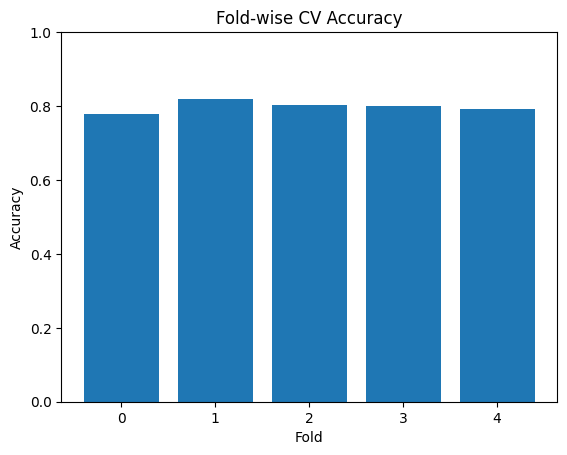

In [ ]:
# 5 
# Fold ごとのスコア計算と可視化
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

# 各 fold の精度を計算
fold_scores = []
for fold, (_, val_idx) in enumerate(sgkf.split(train, train[TARGET], groups)):
    acc = accuracy_score(train.iloc[val_idx][TARGET], oof_preds[val_idx])
    fold_scores.append(acc)
    print(f'Fold {fold} acc: {acc:.4f}')

# 棒グラフで可視化
plt.bar(range(len(fold_scores)), fold_scores)
plt.title('Fold-wise CV Accuracy')
plt.xlabel('Fold')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
plt.show()
